# Import necessary Libs

In [1]:
# pip install python-slugify pandas seaborn xgboost scikit-optimize optuna shap

In [2]:
import numpy as np
import optuna
import pandas as pd
import shap
import xgboost

import matplotlib.pyplot as plt
import seaborn as sns
from slugify import slugify
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn import metrics
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu, pointbiserialr
from xgboost import XGBClassifier

In [3]:
pd.options.display.max_columns=50

# Read data

In [4]:
data_file_name = 'Customer-Churn.xlsx'

In [5]:
def _slugify(word):
    return slugify(word, separator='_')

In [6]:
df = (
    pd.read_excel(data_file_name)
    .rename(columns=lambda col: _slugify(col))
    .pipe(
        lambda df: df.assign(
            **{col: df[col].apply(_slugify) for col in df.dtypes[df.dtypes == 'object'].index}
        )
    )
    .assign(churn=lambda df: (df['churn'] == 'yes').astype(int))
    .set_index('customerid')
)

# Dataset Overview

In [7]:
df.sample(5).T

customerid,6080_tcmyc,3778_foaqw,5438_qmddl,9975_skrnr,9747_ddzos
gender,male,female,female,male,female
seniorcitizen,0,0,0,0,0
partner,yes,yes,yes,no,no
dependents,yes,no,no,no,no
tenure,40,24,19,1,1
phoneservice,yes,yes,yes,yes,yes
multiplelines,yes,no,no,no,no
internetservice,fiber_optic,no,dsl,no,fiber_optic
onlinesecurity,no,no_internet_service,no,no_internet_service,no
onlinebackup,no,no_internet_service,yes,no_internet_service,no


# Dataset Info

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7569_nmzyq to 6823_sidfq
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   int64  
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   phoneservice      7043 non-null   object 
 6   multiplelines     7043 non-null   object 
 7   internetservice   7043 non-null   object 
 8   onlinesecurity    7043 non-null   object 
 9   onlinebackup      7043 non-null   object 
 10  deviceprotection  7043 non-null   object 
 11  techsupport       7043 non-null   object 
 12  streamingtv       7043 non-null   object 
 13  streamingmovies   7043 non-null   object 
 14  contract          7043 non-null   object 
 15  paperlessbilling  7043 non-null   object 
 16  paymentmethod     7043 non-null 

# Missing Data

In [9]:
df.isnull().sum()

gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
multiplelines        0
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
contract             0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64

In [10]:
df[df['totalcharges'].isnull()][['tenure', 'monthlycharges','totalcharges','churn']]

,tenure,monthlycharges,totalcharges,churn
customerid,,,,
5709_lvoeq,0,80.85,NaN,0
4075_wkniu,0,73.35,NaN,0
2775_sefee,0,61.90,NaN,0
1371_dwpaz,0,56.05,NaN,0
4472_lvygi,0,52.55,NaN,0
4367_nuyao,0,25.75,NaN,0
3213_vvolg,0,25.35,NaN,0
3115_czmzd,0,20.25,NaN,0
2520_sgtta,0,20.00,NaN,0


temos 11 amostras com totalcharges nulas, todas elas com tenure 0. uma hipótese é que ainda não foram realizados pagamentos e por consequencia estes valores são nulos, neste caso poderíamos preenche-los com 0

# Statistical Analysis

In [11]:
numerical_features=['tenure', 'monthlycharges', 'totalcharges']

categorical_features=[
     'multiplelines', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies', 'contract', 'paymentmethod',
    ]

boolean_features=['gender', 'seniorcitizen', 'partner', 'dependents',    'phoneservice',  'paperlessbilling',]

target='churn'

In [12]:
df[numerical_features].corr()

,tenure,monthlycharges,totalcharges
tenure,1.00000,0.247900,0.825880
monthlycharges,0.24790,1.000000,0.651065
totalcharges,0.82588,0.651065,1.000000


totalcharges tem correlação de 0.826 com tenure e 0.65 com monthlycharges

In [13]:
for col in numerical_features:
    churn_yes = df[df['churn'] == 1][col].dropna()
    churn_no = df[df['churn'] == 0][col].dropna()
    t_stat, p_val = ttest_ind(churn_yes, churn_no)
    print(f"{col}: t-stat={t_stat:.3f}, p-value={p_val:.3f}")

tenure: t-stat=-31.580, p-value=0.000
monthlycharges: t-stat=16.537, p-value=0.000
totalcharges: t-stat=-17.069, p-value=0.000


In [14]:
for col in categorical_features+boolean_features:
    contingency_table = pd.crosstab(df[col], df['churn'])
    chi2, p_val, _, _ = chi2_contingency(contingency_table)
    print(f"{col}: chi2={chi2:.3f}, p-value={p_val:.3f}")

multiplelines: chi2=11.330, p-value=0.003
internetservice: chi2=732.310, p-value=0.000
onlinesecurity: chi2=849.999, p-value=0.000
onlinebackup: chi2=601.813, p-value=0.000
deviceprotection: chi2=558.419, p-value=0.000
techsupport: chi2=828.197, p-value=0.000
streamingtv: chi2=374.204, p-value=0.000
streamingmovies: chi2=375.661, p-value=0.000
contract: chi2=1184.597, p-value=0.000
paymentmethod: chi2=648.142, p-value=0.000
gender: chi2=0.484, p-value=0.487
seniorcitizen: chi2=159.426, p-value=0.000
partner: chi2=158.733, p-value=0.000
dependents: chi2=189.129, p-value=0.000
phoneservice: chi2=0.915, p-value=0.339
paperlessbilling: chi2=258.278, p-value=0.000


In [15]:
for col in boolean_features:
    contingency_table = pd.crosstab(df[col], df['churn'])
    chi2, p_val, _, _ = chi2_contingency(contingency_table)
    print(f"{col}: chi2={chi2:.3f}, p-value={p_val:.3f}")

gender: chi2=0.484, p-value=0.487
seniorcitizen: chi2=159.426, p-value=0.000
partner: chi2=158.733, p-value=0.000
dependents: chi2=189.129, p-value=0.000
phoneservice: chi2=0.915, p-value=0.339
paperlessbilling: chi2=258.278, p-value=0.000


In [16]:
df['churn'].value_counts()

churn
0    5174
1    1869
Name: count, dtype: int64

In [17]:
df['churn'].mean()

0.2653698707936959

In [18]:
churn=1869
no_churn=5174

# Numerical Features Distribution

<Figure size 1200x600 with 0 Axes>

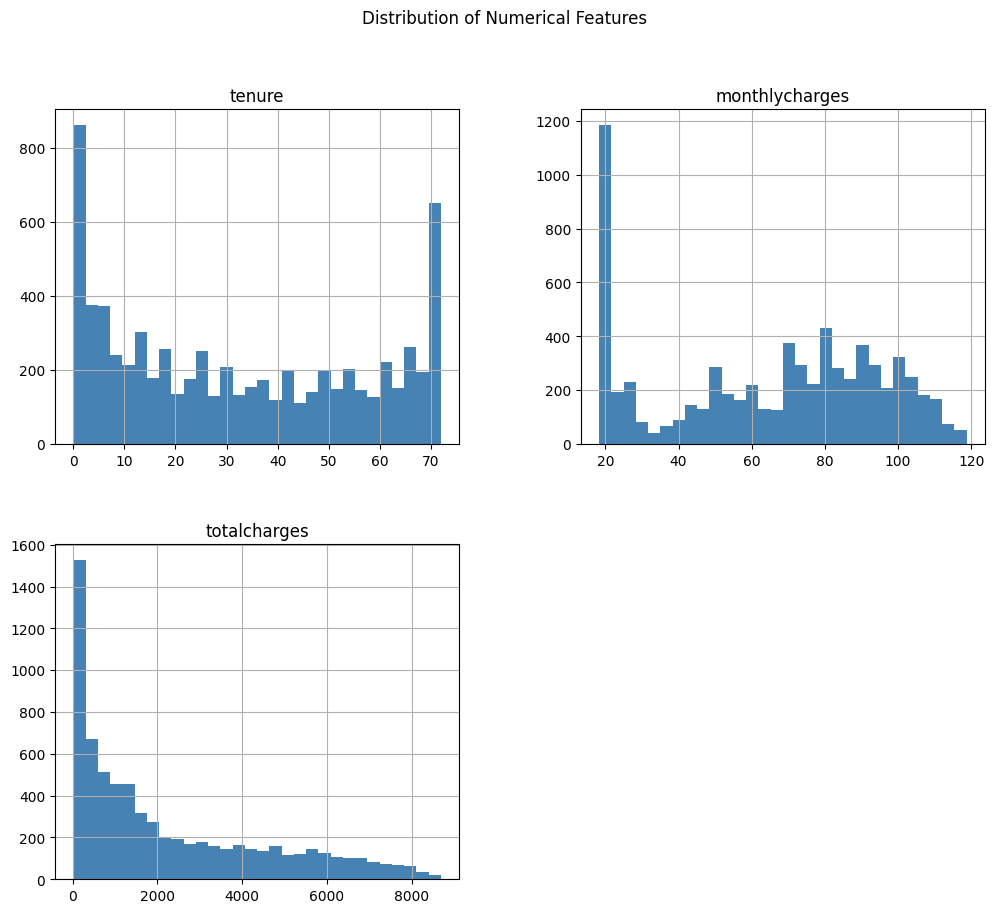

In [19]:
plt.figure(figsize=(12, 6))
df[numerical_features].hist(bins=30, figsize=(12, 10), color='steelblue')
plt.suptitle("Distribution of Numerical Features")
plt.show()

## Churn Histogram Plots

In [20]:
def plot_churn_distribution(df):
    df.groupby('churn').size().plot(kind='bar', stacked=False, color=['orange', 'teal'], figsize=(10, 6))
    plt.title(f'Churn distribution', fontsize=14, weight='bold')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(rotation=0)
    plt.legend(title='Churn', labels=['No', 'Yes'], loc='upper right')
    plt.tight_layout()
    plt.show()


def ttest_chi2(df, column):
    if column in numerical_features:
        churn_yes = df[df['churn'] == 1][column].dropna()
        churn_no = df[df['churn'] == 0][column].dropna()
        t_stat, p_val = ttest_ind(churn_yes, churn_no)
        print(f"{column}: t-stat={t_stat:.3f}, p-value={p_val:.3f}")
        print()

    if column in categorical_features+boolean_features:
        contingency_table = pd.crosstab(df[column], df['churn'])
        chi2, p_val, _, _ = chi2_contingency(contingency_table)
        print(f"{column}: chi2={chi2:.3f}, p-value={p_val:.3f}")
        print()

def plot_churn_histogram(df, column):
    data = df.groupby([column, 'churn']).size().unstack()
    data.plot(kind='bar', stacked=False, color=['orange', 'teal'],  figsize=(10, 6))
    plt.title(f'Churn by {column}', fontsize=14, weight='bold')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(rotation=0)
    plt.legend(title='Churn', labels=['No', 'Yes'], loc='upper right')
    plt.tight_layout()
    plt.show()

    ttest_chi2(df,column)
    


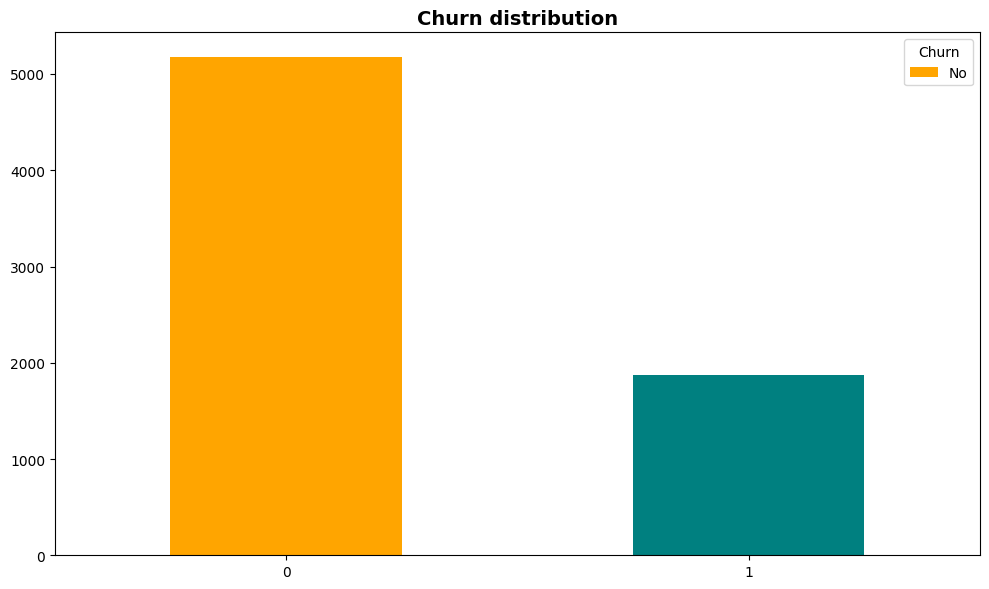

In [21]:
plot_churn_distribution(df)

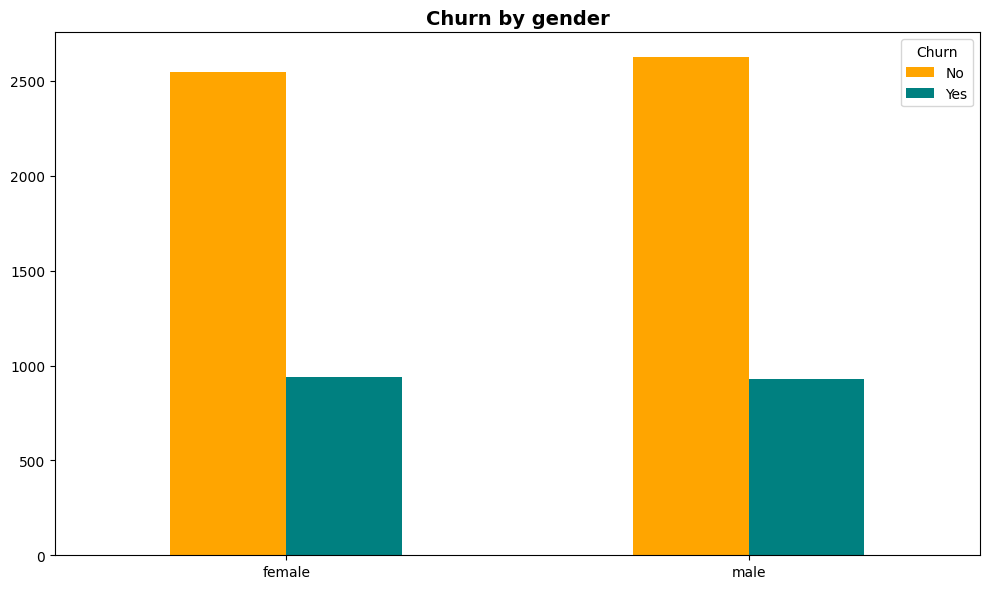

gender: chi2=0.484, p-value=0.487



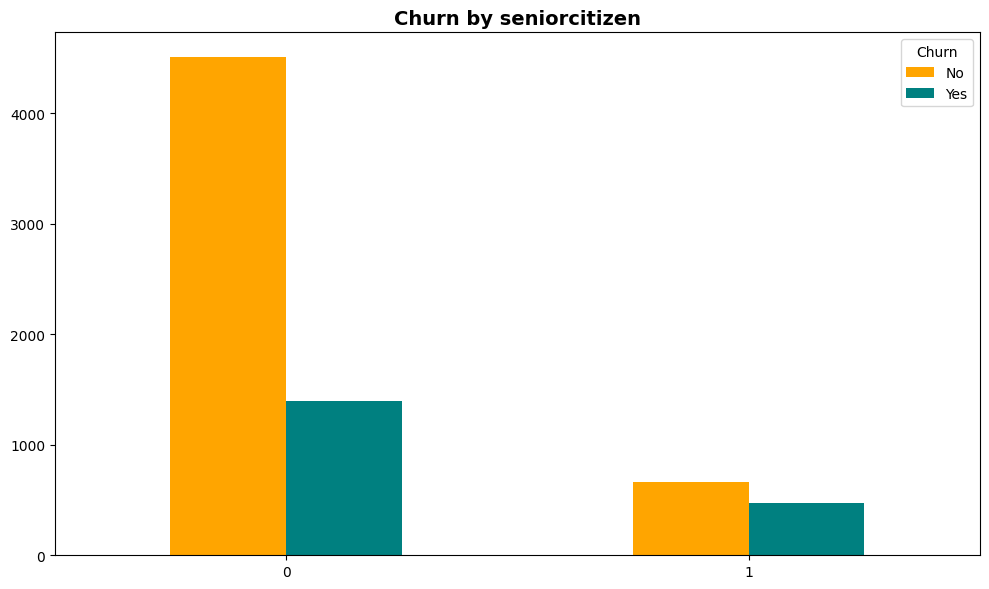

seniorcitizen: chi2=159.426, p-value=0.000



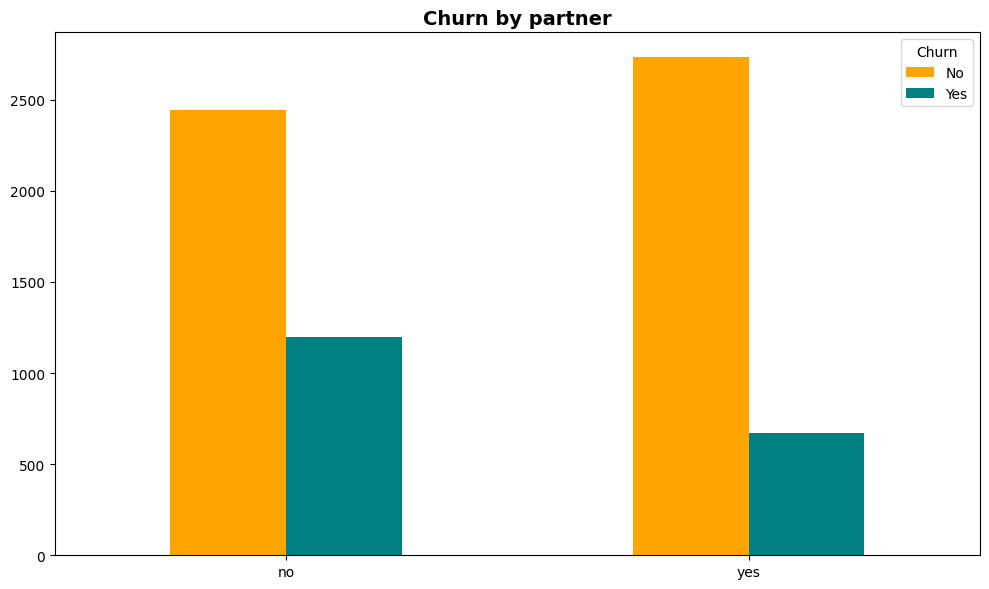

partner: chi2=158.733, p-value=0.000



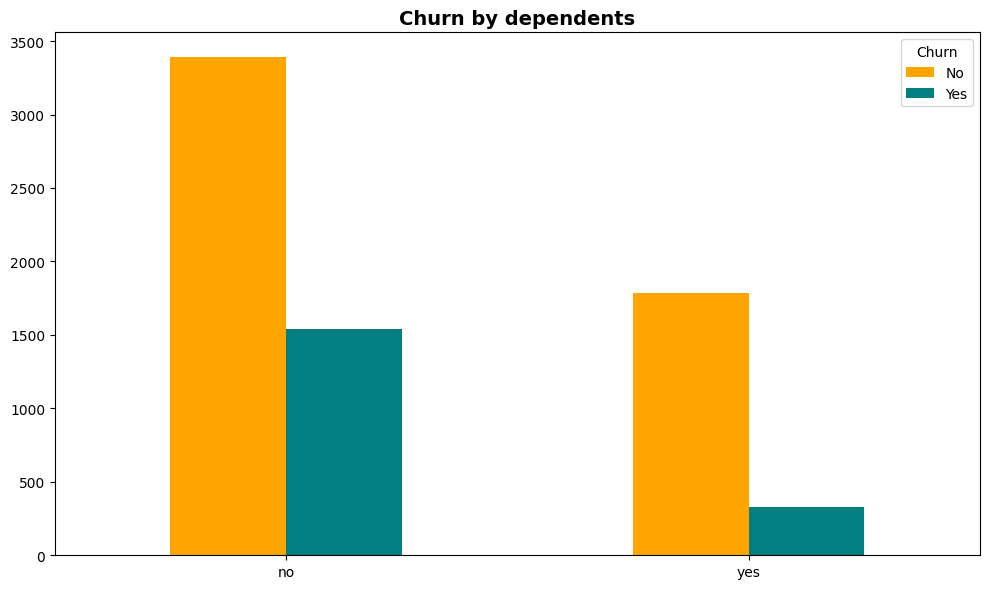

dependents: chi2=189.129, p-value=0.000



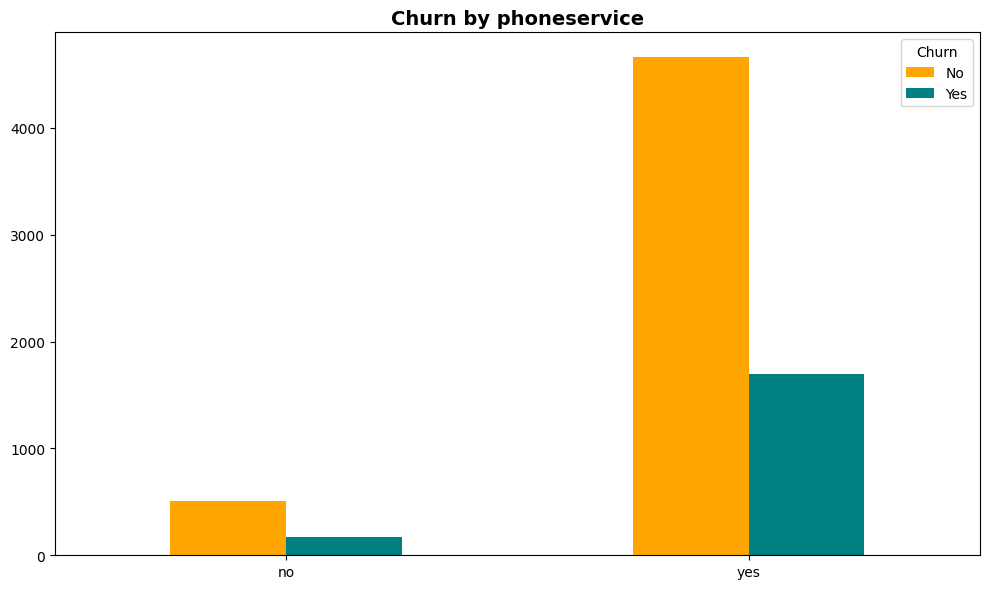

phoneservice: chi2=0.915, p-value=0.339



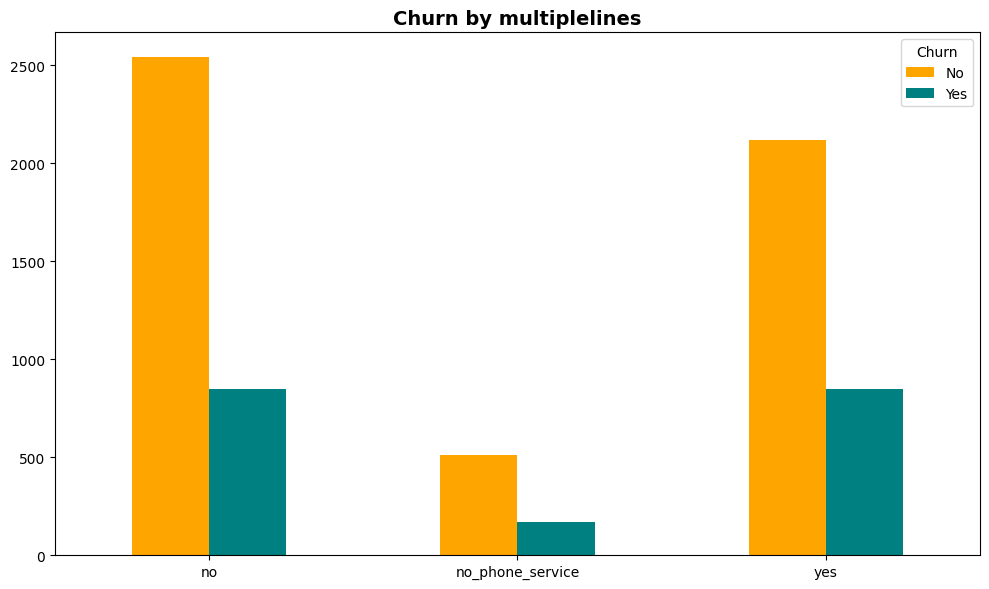

multiplelines: chi2=11.330, p-value=0.003



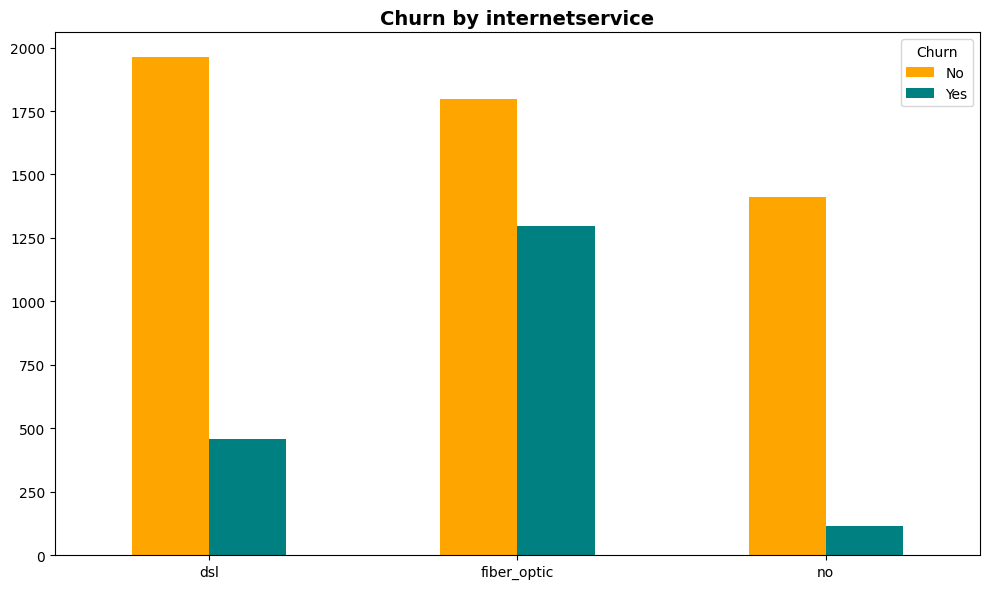

internetservice: chi2=732.310, p-value=0.000



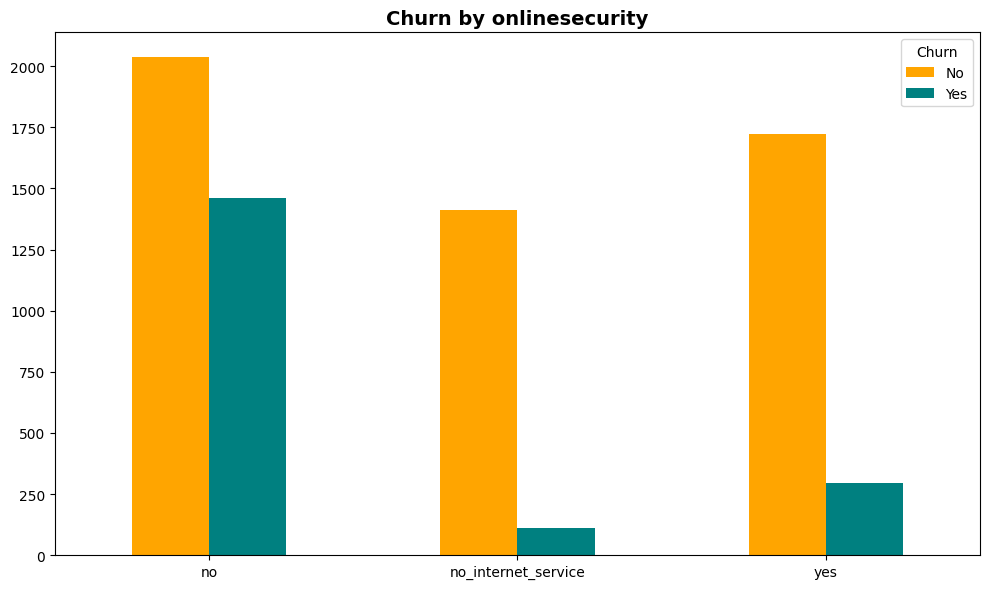

onlinesecurity: chi2=849.999, p-value=0.000



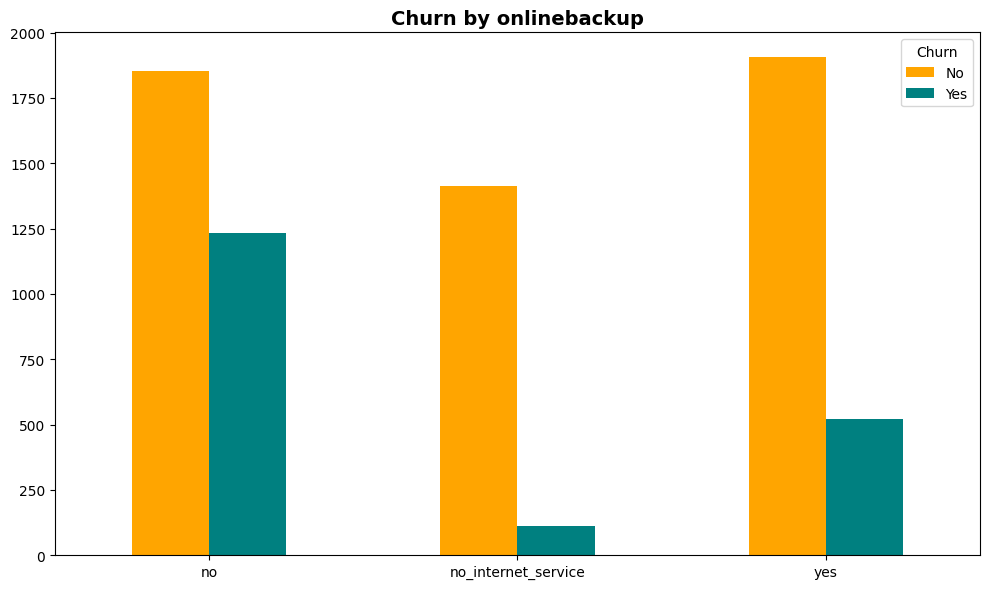

onlinebackup: chi2=601.813, p-value=0.000



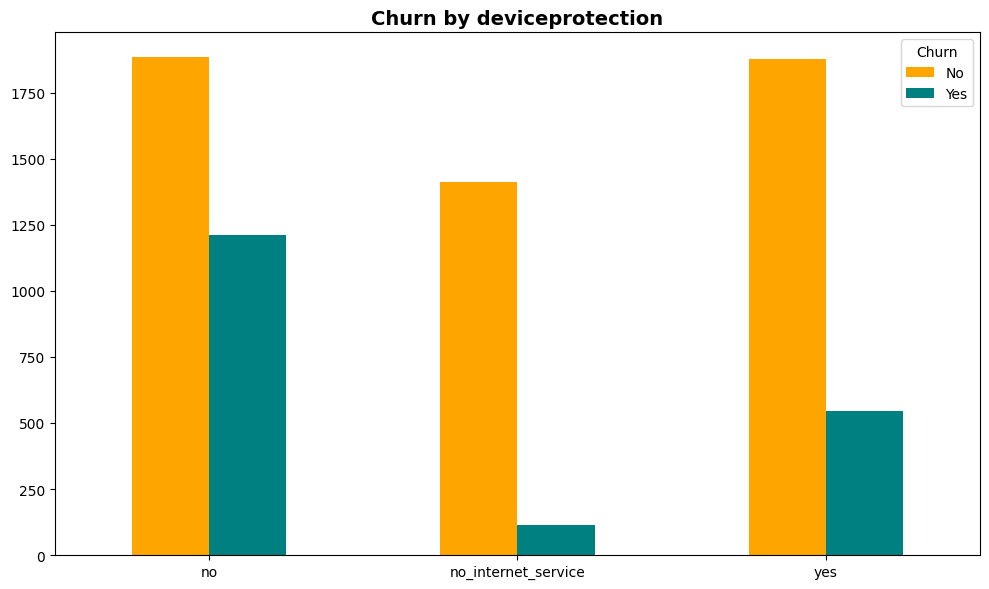

deviceprotection: chi2=558.419, p-value=0.000



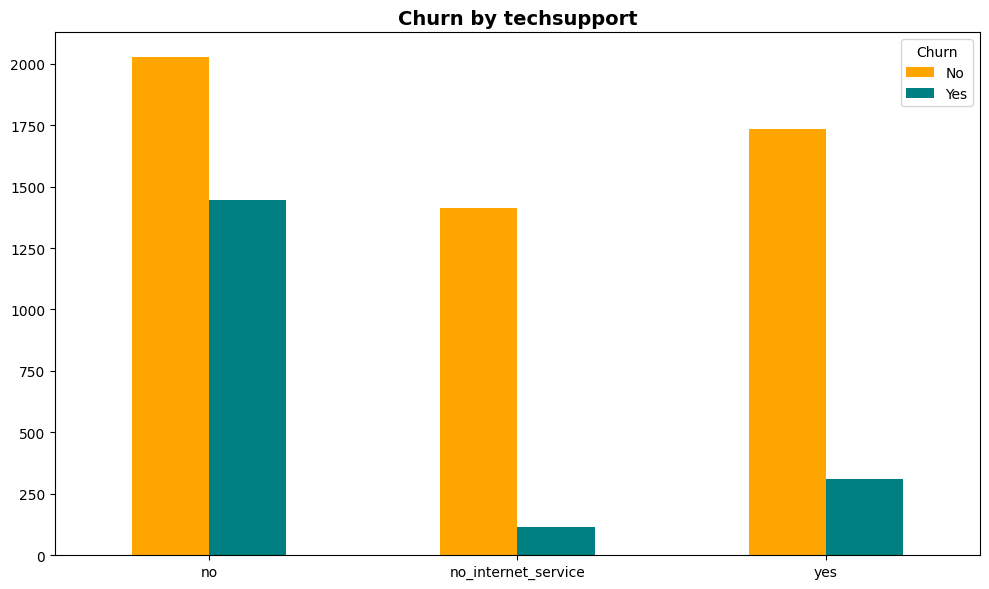

techsupport: chi2=828.197, p-value=0.000



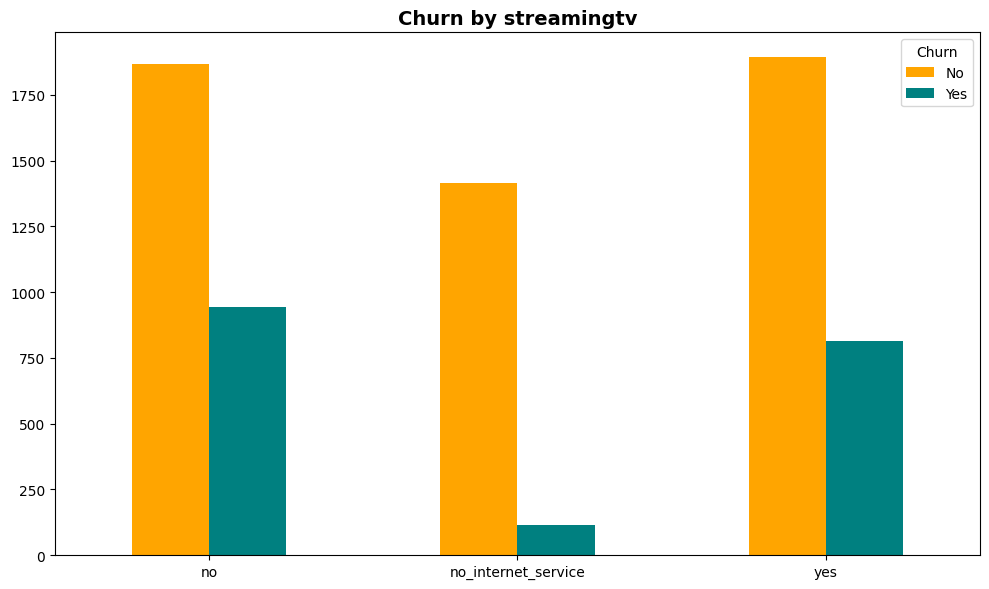

streamingtv: chi2=374.204, p-value=0.000



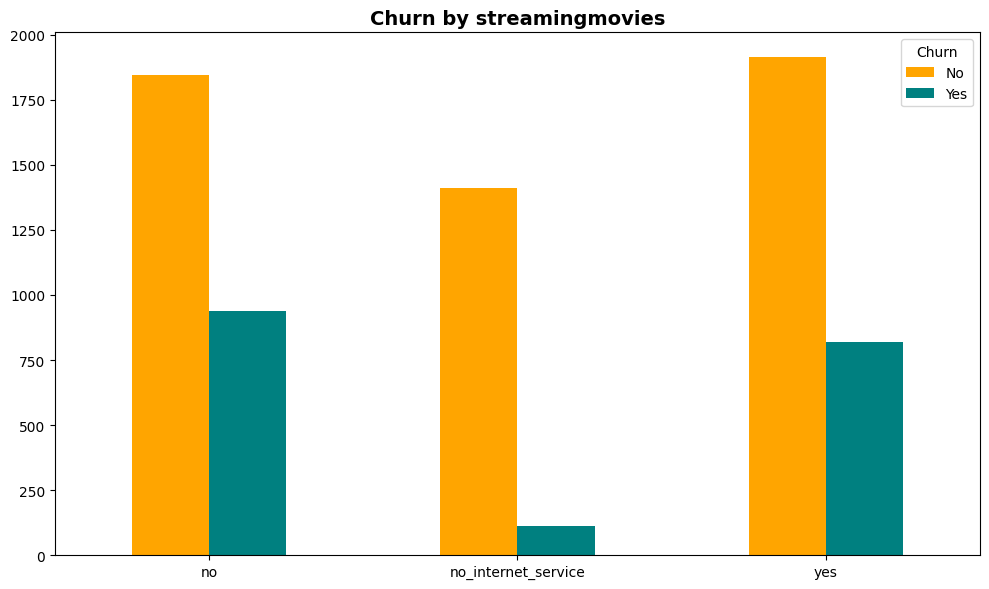

streamingmovies: chi2=375.661, p-value=0.000



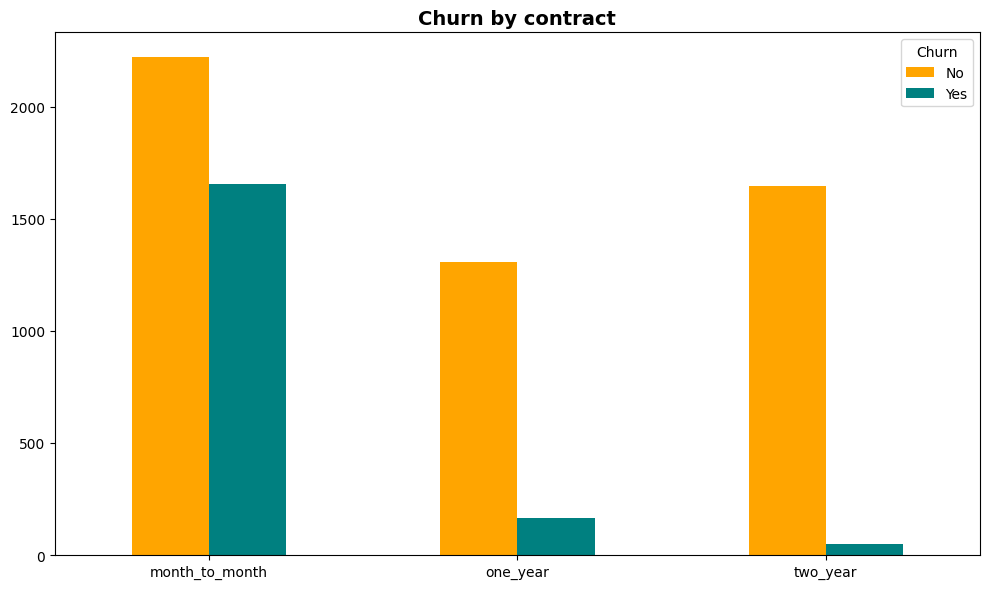

contract: chi2=1184.597, p-value=0.000



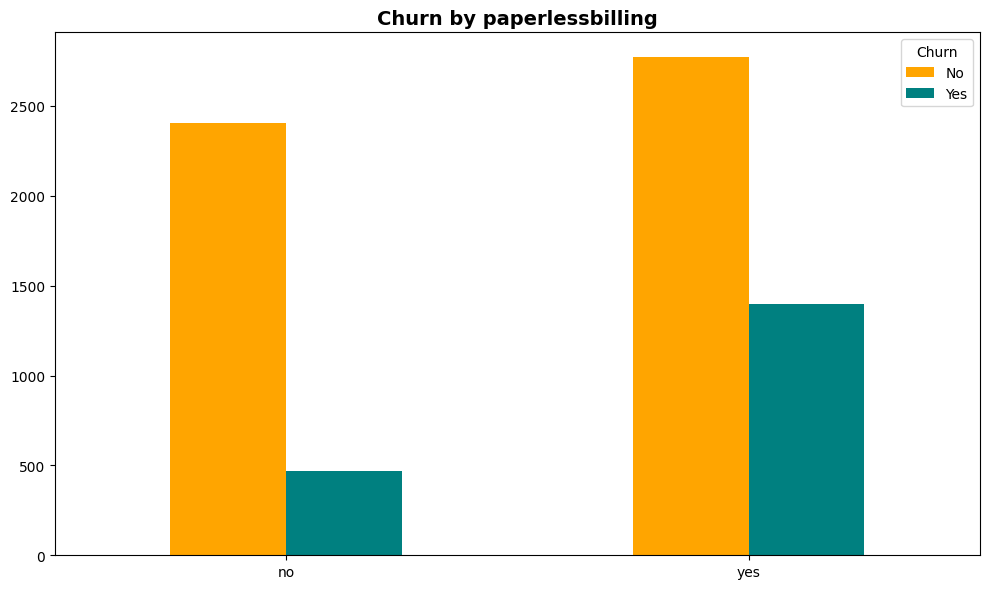

paperlessbilling: chi2=258.278, p-value=0.000



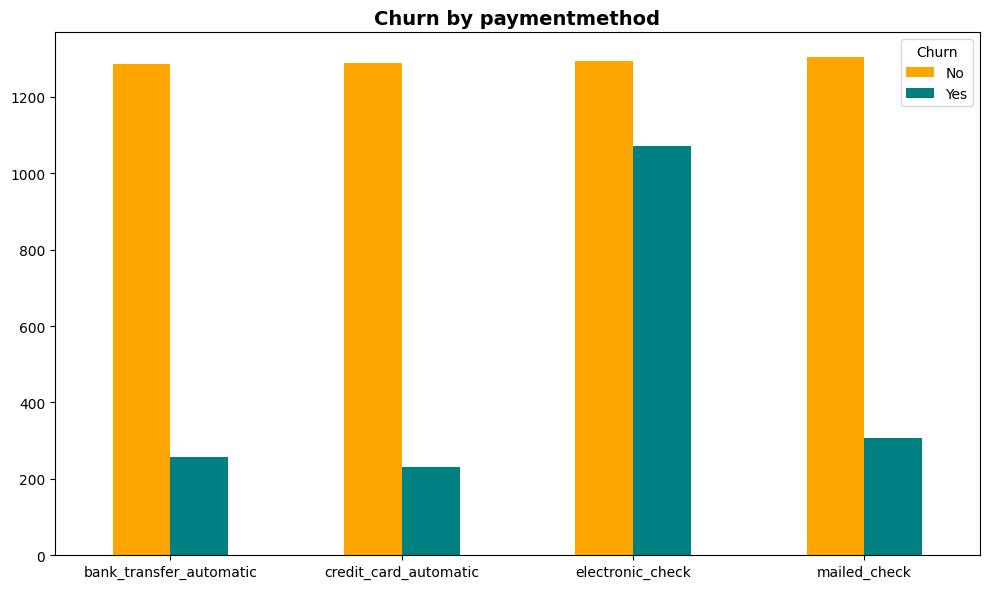

paymentmethod: chi2=648.142, p-value=0.000



In [22]:
for column in df.columns:
    if column not in ['tenure', 'monthlycharges', 'totalcharges', 'churn']:
        plot_churn_histogram(df, column)

we can observe that there is association between the categorical and boolean features and churn.
phoneservice and gender are some of the few that do not have strong association

# Hypothesis

## Clients with month_to_month contracts have higher churn

In [23]:
churn/(no_churn+churn)

0.2653698707936959

In [24]:
ttest_chi2(df, 'contract')

contract: chi2=1184.597, p-value=0.000



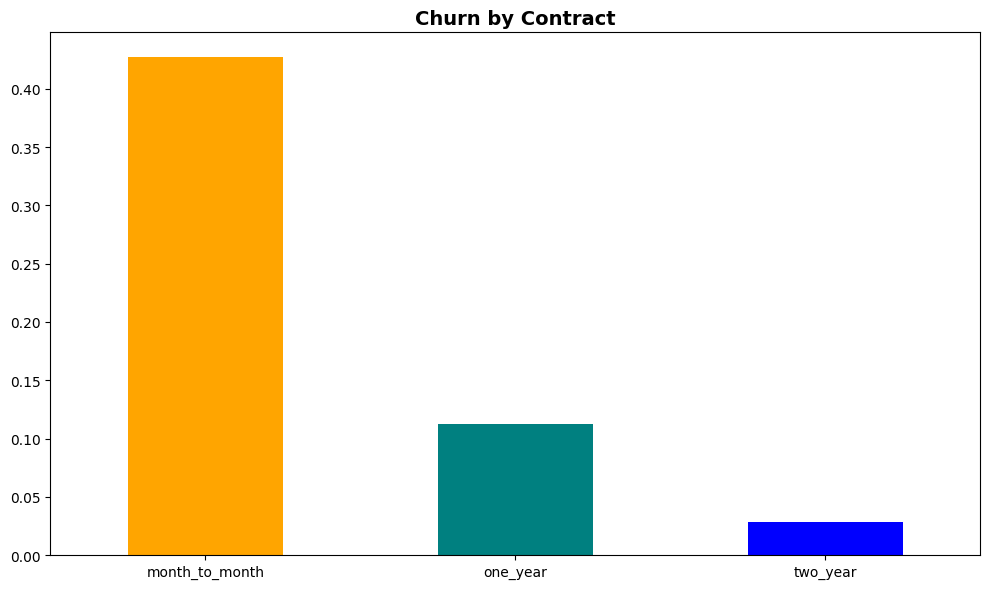

In [25]:
df.groupby(['contract'])['churn'].mean().plot(kind='bar', stacked=False, color=['orange', 'teal', 'blue'], figsize=(10, 6))
plt.title(f'Churn by Contract', fontsize=14, weight='bold')
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
df.groupby(['contract'])['churn'].size()

contract
month_to_month    3875
one_year          1473
two_year          1695
Name: churn, dtype: int64

In [27]:
df.groupby(['contract'])['churn'].mean()

contract
month_to_month    0.427097
one_year          0.112695
two_year          0.028319
Name: churn, dtype: float64

In [28]:
0.427097-0.112695

0.314402

In [29]:
0.427097-0.028319

0.398778

## Fiberoptic internet clients have higer churn

In [30]:
ttest_chi2(df, 'internetservice')

internetservice: chi2=732.310, p-value=0.000



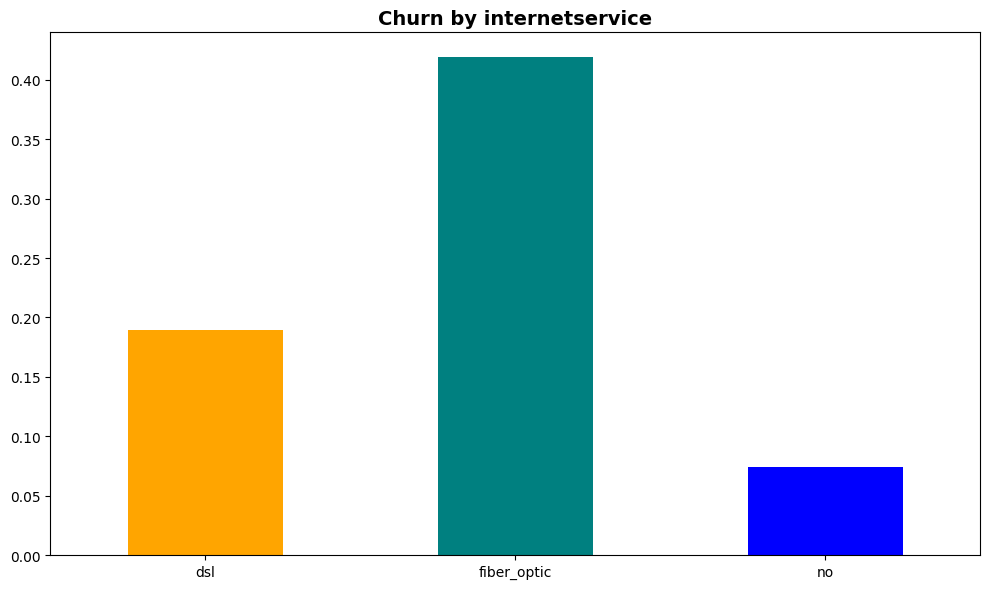

In [31]:
df.groupby(['internetservice'])['churn'].mean().plot(kind='bar', stacked=False, color=['orange', 'teal', 'blue'], figsize=(10, 6))
plt.title(f'Churn by internetservice', fontsize=14, weight='bold')
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Clients with higher monthly charges are more likely to churn

In [32]:
group_churned = df[df['churn'] == 1]['monthlycharges']
group_not_churned = df[df['churn'] == 0]['monthlycharges']

u_stat, p_value = mannwhitneyu(group_churned, group_not_churned)
print(f'U-statistic: {u_stat}, p-value: {p_value}')

U-statistic: 6003125.5, p-value: 3.311627651988586e-54


In [33]:
correlation, p_value = pointbiserialr(df['churn'], df['monthlycharges'])

print(f"Point-Biserial Correlation: {correlation}")
print(f"P-value: {p_value}")

Point-Biserial Correlation: 0.19335642223784705
P-value: 2.7066456068881927e-60


In [34]:
_df=df.copy(deep=True)
_df['strata'] = pd.qcut(_df['monthlycharges'], q=4)

/var/folders/x5/y48gfrrj4_b3lkjrk7frvv1h0000gn/T/ipykernel_68544/980773839.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _df.groupby(['strata'])['churn'].mean().plot(kind='bar', stacked=False, color=['orange', 'teal', 'blue'], figsize=(10, 6))


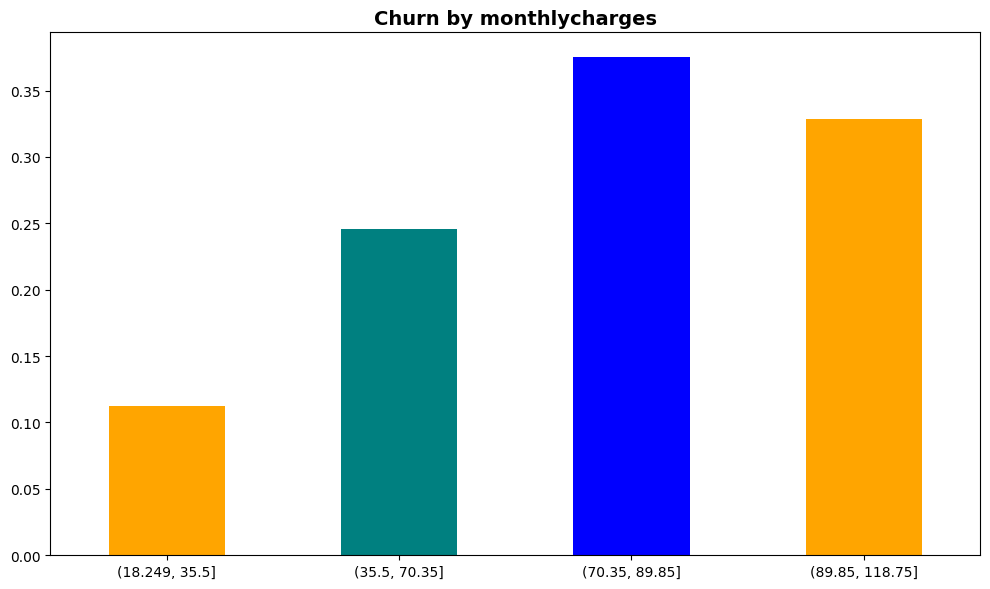

In [35]:
_df.groupby(['strata'])['churn'].mean().plot(kind='bar', stacked=False, color=['orange', 'teal', 'blue'], figsize=(10, 6))
plt.title(f'Churn by monthlycharges', fontsize=14, weight='bold')
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Clients with higher tenure are less likely to churn

In [36]:
group_churned = df[df['churn'] == 1]['tenure']
group_not_churned = df[df['churn'] == 0]['tenure']

u_stat, p_value = mannwhitneyu(group_churned, group_not_churned)
print(f'U-statistic: {u_stat}, p-value: {p_value}')

U-statistic: 2515538.0, p-value: 2.419635517951866e-208


In [37]:
correlation, p_value = pointbiserialr(df['churn'], df['tenure'])

print(f"Point-Biserial Correlation: {correlation}")
print(f"P-value: {p_value}")

Point-Biserial Correlation: -0.352228670113078
P-value: 7.999057960589449e-205


In [38]:
_df=df.copy(deep=True)
_df['strata'] = pd.qcut(_df['tenure'], q=4)

/var/folders/x5/y48gfrrj4_b3lkjrk7frvv1h0000gn/T/ipykernel_68544/3599090624.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _df.groupby(['strata'])['churn'].mean().plot(kind='bar', stacked=False, color=['orange', 'teal', 'blue'], figsize=(10, 6))


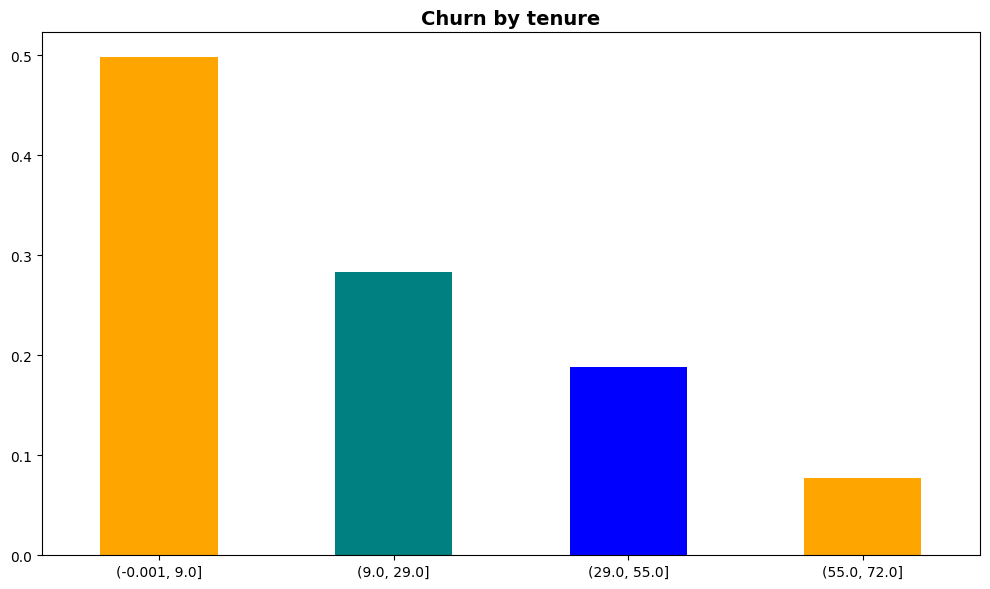

In [39]:
_df.groupby(['strata'])['churn'].mean().plot(kind='bar', stacked=False, color=['orange', 'teal', 'blue'], figsize=(10, 6))
plt.title(f'Churn by tenure', fontsize=14, weight='bold')
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Train Test Split

In [40]:
df_train_full, X_test = train_test_split(df.fillna(0)
                                          # .drop(columns=['totalcharges','monthlycharges'])
                                          , test_size=0.2, random_state=0)
X_train, X_val = train_test_split(df_train_full, test_size=0.33, random_state=0)


y_train = X_train.pop('churn')
y_val = X_val.pop('churn')
y_test = X_test.pop('churn')

## OneHotEncoder

In [41]:
def apply_encoder_transform(df, columns, encoder):
    encoded_data = encoder.transform(df[columns])
    encoded_columns = encoder.get_feature_names_out(columns)
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns, index=df.index)
    
    df = df.drop(columns, axis=1)
    df = pd.concat([df, encoded_df], axis=1)

    return df

In [42]:
encoder = OneHotEncoder(sparse_output=False, drop='if_binary')  # to avoid multicollinearity

encoder.fit(X_train[categorical_features])

OneHotEncoder(drop='if_binary', sparse_output=False)

In [43]:
X_train=apply_encoder_transform(X_train, categorical_features, encoder)

X_val=apply_encoder_transform(X_val, categorical_features, encoder)

X_test=apply_encoder_transform(X_test, categorical_features, encoder)

# Label Encoder

In [44]:
def apply_label_encoder(df, columns):
    label_encoder = LabelEncoder()
    
    for column in columns:
        df[column] = label_encoder.fit_transform(df[column])
    
    return df

In [45]:
X_train=apply_label_encoder(X_train, boolean_features)

X_val=apply_label_encoder(X_val, boolean_features)

X_test=apply_label_encoder(X_test, boolean_features)

# Train Logistic Regression

In [46]:
def plot_roc_curve(y, y_proba, estimator_name):
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name=estimator_name)
    display.plot()
    plt.show()

In [47]:
X_train_standard=X_train.copy(deep=True)
X_val_standard=X_val.copy(deep=True)
X_test_standard=X_test.copy(deep=True)

In [48]:
scaler = MinMaxScaler()

X_train_standard[numerical_features]=scaler.fit_transform(X_train[numerical_features])

X_val_standard[numerical_features]=scaler.transform(X_val[numerical_features])

X_test_standard[numerical_features]=scaler.transform(X_test[numerical_features])

In [49]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train_standard, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [50]:
y_val_proba = model.predict_proba(X_val_standard)[:, 1]

y_val_pred = y_val_proba > 0.5

precision_recall_fscore_support(y_val, y_val_pred, average='weighted')

(0.789641773239469, 0.7994623655913978, 0.7911179628022812, None)

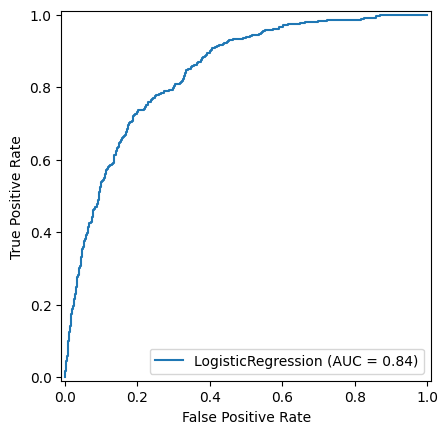

In [51]:
plot_roc_curve(y_val, y_val_proba, 'LogisticRegression')

In [52]:
y_test_proba = model.predict_proba(X_test_standard)[:, 1]

y_test_pred = y_test_proba > 0.5

precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

(0.795350416901722, 0.8041163946061036, 0.7979944156309361, None)

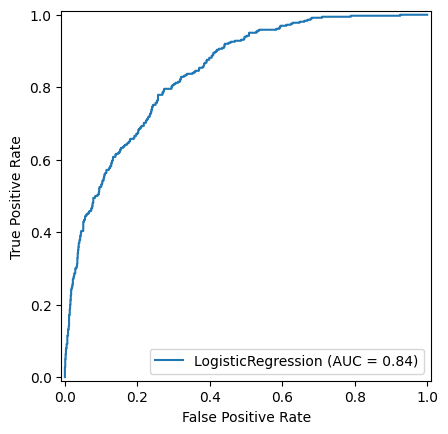

In [53]:
plot_roc_curve(y_test, y_test_proba, 'LogisticRegression')

In [54]:
pd.DataFrame([X_test_standard.columns,model.coef_[0]]).T.rename(columns={0: 'feature', 1:'coefficient'}).sort_values(by='coefficient', ascending=False)

,feature,coefficient
8,totalcharges,0.860276
33,contract_month_to_month,0.585556
13,internetservice_fiber_optic,0.436099
6,paperlessbilling,0.314925
1,seniorcitizen,0.274352
38,paymentmethod_electronic_check,0.2301
29,streamingtv_yes,0.182884
15,onlinesecurity_no,0.168373
24,techsupport_no,0.139047
18,onlinebackup_no,0.107725


In [55]:
df_display=X_val_standard

In [56]:
explainer = shap.Explainer(model, X_train_standard)
shap_values = explainer(df_display)

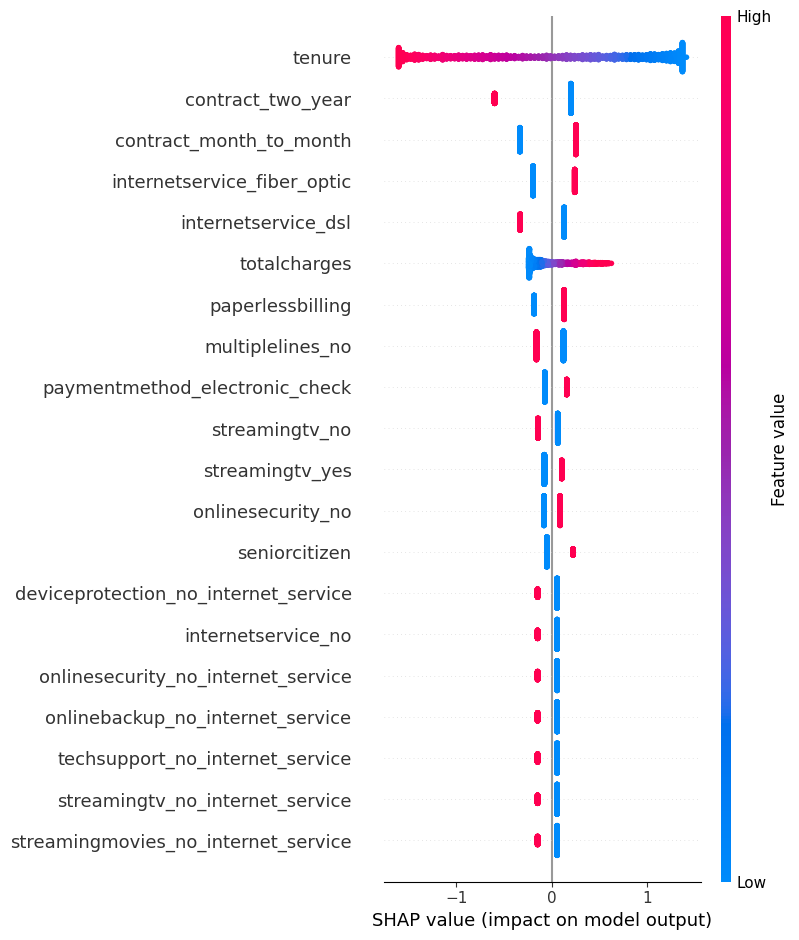

In [57]:
shap.summary_plot(shap_values, df_display)


# Train Xgboost

In [58]:
d_train = xgboost.DMatrix(X_train, label=y_train)
d_val = xgboost.DMatrix(X_val, label=y_val)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [59]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_val, "val")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

[0]	val-logloss:0.58382
[100]	val-logloss:0.45863
[200]	val-logloss:0.43402
[300]	val-logloss:0.43224
[312]	val-logloss:0.43227


In [60]:
y_val_proba = model.predict(d_val)

y_val_pred = y_val_proba > 0.5

precision_recall_fscore_support(y_val, y_val_pred, average='weighted')

(0.7731959862916061, 0.7865591397849462, 0.7729101574778988, None)

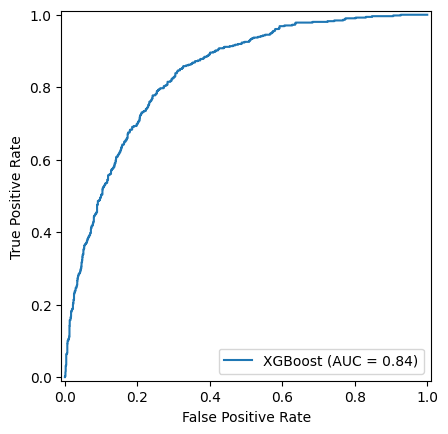

In [61]:
plot_roc_curve(y_val, y_val_proba, 'XGBoost')

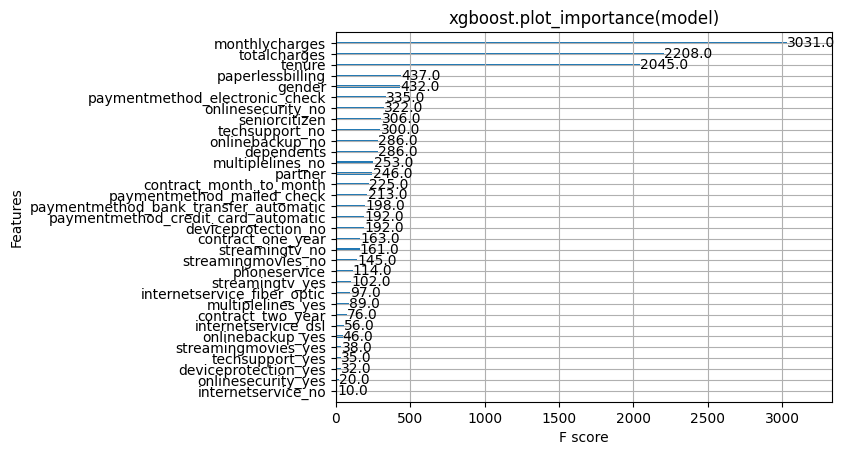

In [62]:
xgboost.plot_importance(model)
plt.title("xgboost.plot_importance(model)")
plt.show()

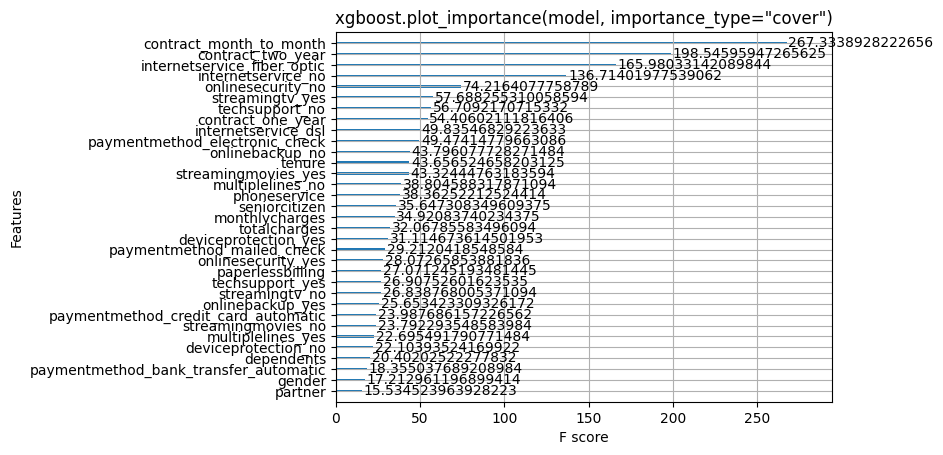

In [63]:
xgboost.plot_importance(model, importance_type="cover")
plt.title('xgboost.plot_importance(model, importance_type="cover")')
plt.show()

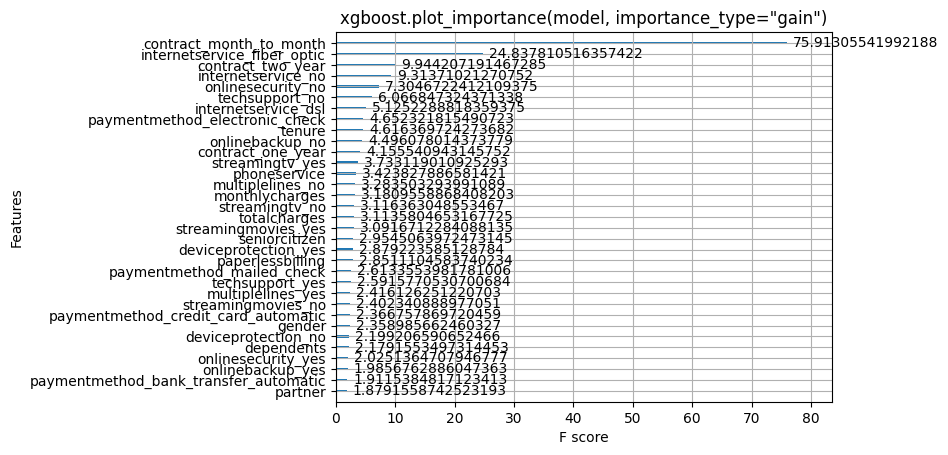

In [64]:
xgboost.plot_importance(model, importance_type="gain")
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()

In [65]:
df_display=X_val

In [66]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_display)

In [67]:
shap.force_plot(explainer.expected_value, shap_values[1, :], df_display.iloc[1, :])

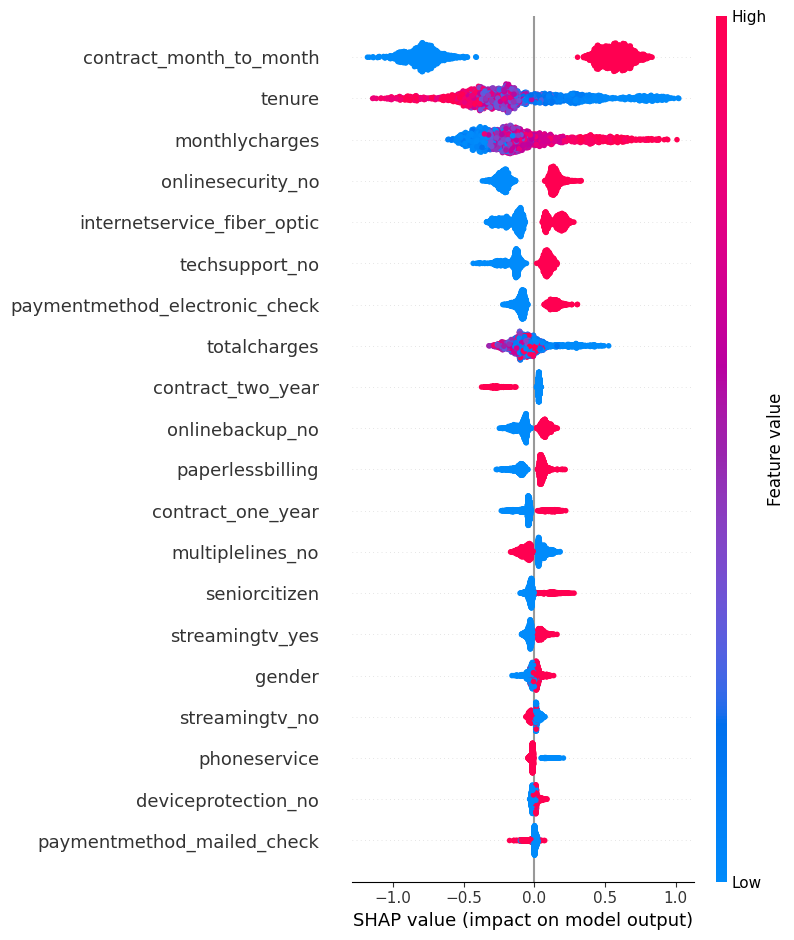

In [68]:
shap.summary_plot(shap_values, df_display)